In [266]:
import re
from scipy.stats import chisquare, ttest_ind
from itertools import combinations
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean, braycurtis
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage
import multiprocessing
import ete3
from Bio import AlignIO
import random

%cd /work/site_rate/hug_et_al/

/work/site_rate/hug_et_al


In [2]:
import matplotlib.colors

cmap = plt.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-1, vmax=12)
colors = ['#%02x%02x%02x' % cmap(norm(index), bytes=8)[:3]
          for index in range(0,13)]

In [3]:
lg_frequencies  = np.asarray(
                      [0.079066, 0.055941, 0.041977, 0.053052,
                       0.012937, 0.040767, 0.071586, 0.057337,
                       0.022355, 0.062157, 0.099081, 0.064600,
                       0.022951, 0.042302, 0.044040, 0.061197,
                       0.053287, 0.012066, 0.034155, 0.069147])
lg_aa_order     =     'A         R         N         D\
                       C         Q         E         G\
                       H         I         L         K\
                       M         F         P         S\
                       T         W         Y         V'.split()

In [4]:
fasta = open('ribosomal_concat.fasta').read()
fasta_no_header = '\n'.join(re.findall('^([^>]\S+)$', fasta, re.M))

aa_count             = []
observed_frequencies = []
for aa in lg_aa_order:
    aa_count.append(fasta_no_header.count(aa))

for aa in aa_count:
    observed_frequencies.append(aa/sum(aa_count))
observed_frequencies = np.asarray(observed_frequencies)

In [5]:
sum((observed_frequencies - lg_frequencies)**2)

0.006182872703390046

In [7]:
categories_aa_frequencies = {}
categories_aa_count       = {}
for category in range(1,13):
    fasta = open('categories/%i.aln' % category).read()
    fasta_no_header = '\n'.join(re.findall('^([^>]\S+)$', fasta, re.M))
    
    cat_aa_count             = []
    cat_observed_frequencies = []
    for aa in lg_aa_order:
        cat_aa_count.append(fasta_no_header.count(aa))

    for aa in cat_aa_count:
        cat_observed_frequencies.append(aa/sum(cat_aa_count))
    
    categories_aa_count[      category] = cat_aa_count
    categories_aa_frequencies[category] = np.asarray(cat_observed_frequencies)

[Text(0, 0, '0.0233'),
 Text(0, 0, '0.0897'),
 Text(0, 0, '0.1752'),
 Text(0, 0, '0.2782'),
 Text(0, 0, '0.4004'),
 Text(0, 0, '0.5458'),
 Text(0, 0, '0.721'),
 Text(0, 0, '0.9372'),
 Text(0, 0, '1.2147'),
 Text(0, 0, '1.5957'),
 Text(0, 0, '2.1944'),
 Text(0, 0, '3.8243')]

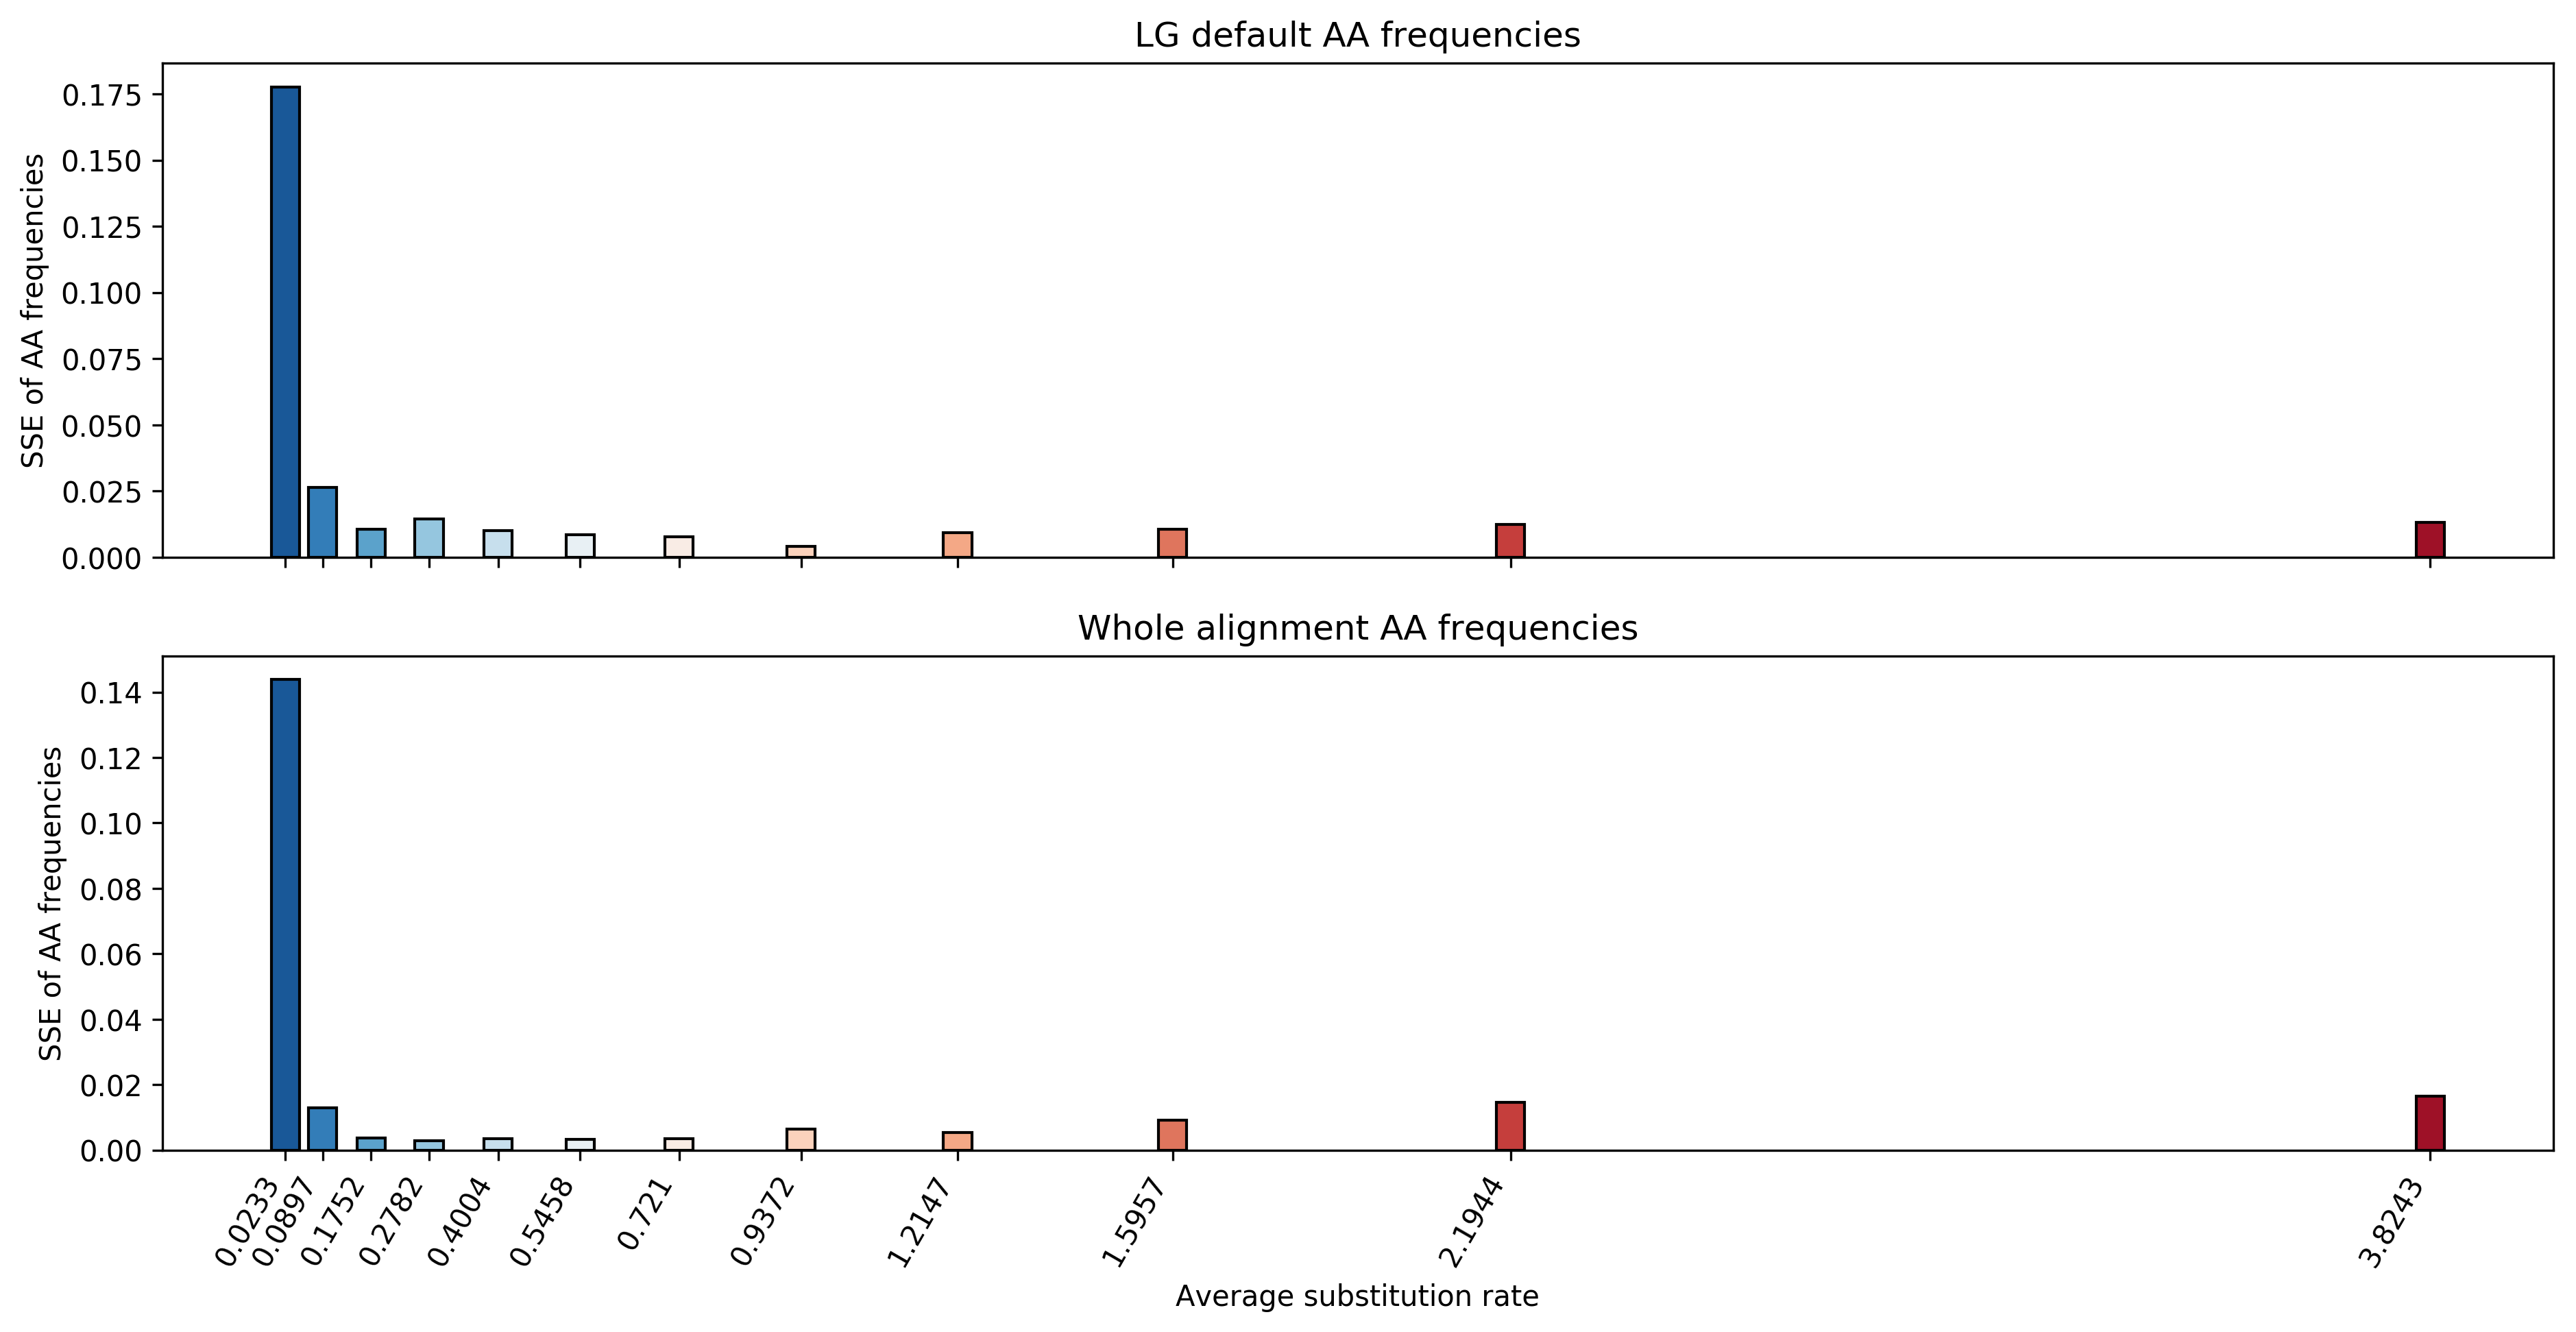

In [8]:
lg_squared_errors = []
for category in range(1,13):
    lg_squared_errors.append(
        sum((categories_aa_frequencies[category] - lg_frequencies)**2)
    )

alignment_squared_errors = []
for category in range(1,13):
    alignment_squared_errors.append(
        sum((categories_aa_frequencies[category] - observed_frequencies)**2)
    )
    
fig, axs = plt.subplots(dpi=300, figsize=(15,7), nrows=2, sharex=True)
axs[0].bar([0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
            0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427],
           lg_squared_errors, width=0.05, color=colors, edgecolor='k')
axs[0].set_title('LG default AA frequencies')
axs[0].set_ylabel('SSE of AA frequencies')

axs[1].bar([0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
            0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427],
           alignment_squared_errors, width=0.05, color=colors, edgecolor='k')
axs[1].set_title('Whole alignment AA frequencies')
axs[1].set_ylabel('SSE of AA frequencies')
axs[1].set_xlabel('Average substitution rate')

axs[1].set_xticks([0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
                   0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427])
axs[1].set_xticklabels([round(n, 4) for n in
                        [0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
                         0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427]],
                       rotation=60, ha='right')

In [170]:
df = pd.DataFrame(columns=lg_aa_order)
for category, frequencies in categories_aa_frequencies.items():
#    df.loc['RSAP%i' % category] = (lg_frequencies - frequencies)**2
    df.loc['RSAP%i' % category] = frequencies
#df.loc['RSAP%i' % 1,'G'] = np.nan
df

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
RSAP1,0.034502,0.145748,0.033757,0.055260,0.000280,0.000216,0.053479,0.440953,0.022875,0.020779,0.001117,0.041381,0.009994,0.011383,0.050488,0.034104,0.022118,0.000063,0.000127,0.021376
RSAP2,0.068190,0.139153,0.050856,0.031156,0.001193,0.027017,0.031865,0.166307,0.024627,0.040882,0.053530,0.085741,0.045758,0.038940,0.038723,0.045459,0.045041,0.010078,0.007976,0.047506
RSAP3,0.120676,0.086611,0.017761,0.035981,0.004616,0.023075,0.048817,0.106606,0.028970,0.063587,0.057953,0.075875,0.025751,0.012184,0.048527,0.066953,0.055174,0.004897,0.022598,0.093388
RSAP4,0.084572,0.102885,0.024353,0.026895,0.007821,0.024251,0.019802,0.110833,0.023426,0.094591,0.063952,0.105036,0.017708,0.029716,0.040281,0.045669,0.062162,0.008596,0.014520,0.092931
RSAP5,0.090482,0.084754,0.028568,0.022373,0.010722,0.022653,0.019152,0.096237,0.014819,0.083524,0.082176,0.077923,0.034477,0.035885,0.047632,0.055186,0.045454,0.007243,0.025455,0.115285
RSAP6,0.081153,0.076338,0.028404,0.033732,0.008968,0.026977,0.035551,0.073644,0.025222,0.098133,0.085638,0.087417,0.030647,0.025111,0.033787,0.049348,0.051878,0.008773,0.017430,0.121850
RSAP7,0.062610,0.075286,0.031931,0.028339,0.007050,0.033903,0.055656,0.059783,0.023607,0.091033,0.087023,0.110356,0.028241,0.025657,0.032545,0.045561,0.043082,0.011751,0.031638,0.114951
RSAP8,0.067478,0.064209,0.037556,0.047601,0.005119,0.033622,0.056565,0.036341,0.021622,0.087237,0.104608,0.092163,0.025513,0.036000,0.032479,0.051288,0.054094,0.004298,0.035526,0.106682
RSAP9,0.068579,0.078042,0.039658,0.042589,0.002710,0.038158,0.073046,0.055567,0.022532,0.050342,0.065524,0.147082,0.017148,0.034830,0.053569,0.050650,0.056540,0.004147,0.025464,0.073820
RSAP10,0.086171,0.063008,0.050114,0.060997,0.002563,0.040272,0.103595,0.065812,0.017496,0.037294,0.052786,0.138235,0.015868,0.022436,0.044748,0.061503,0.058442,0.002787,0.021928,0.053946


In [171]:
col_linkage = linkage(df.T.values, metric='correlation', method='average')
row_linkage = linkage(df.values,   metric='correlation', method='average')
df.loc['RSAP%i' % 1,'G'] = np.nan

In [183]:
clmap.ax_heatmap.set(xlabel='Amino acids', ylabel='Rate-Specific Alignment Partitions')

[Text(7454.432291666665, 0.5, 'Rate-Specific Alignment Partitions'),
 Text(0.5, 26.66666666666658, 'Amino acids')]

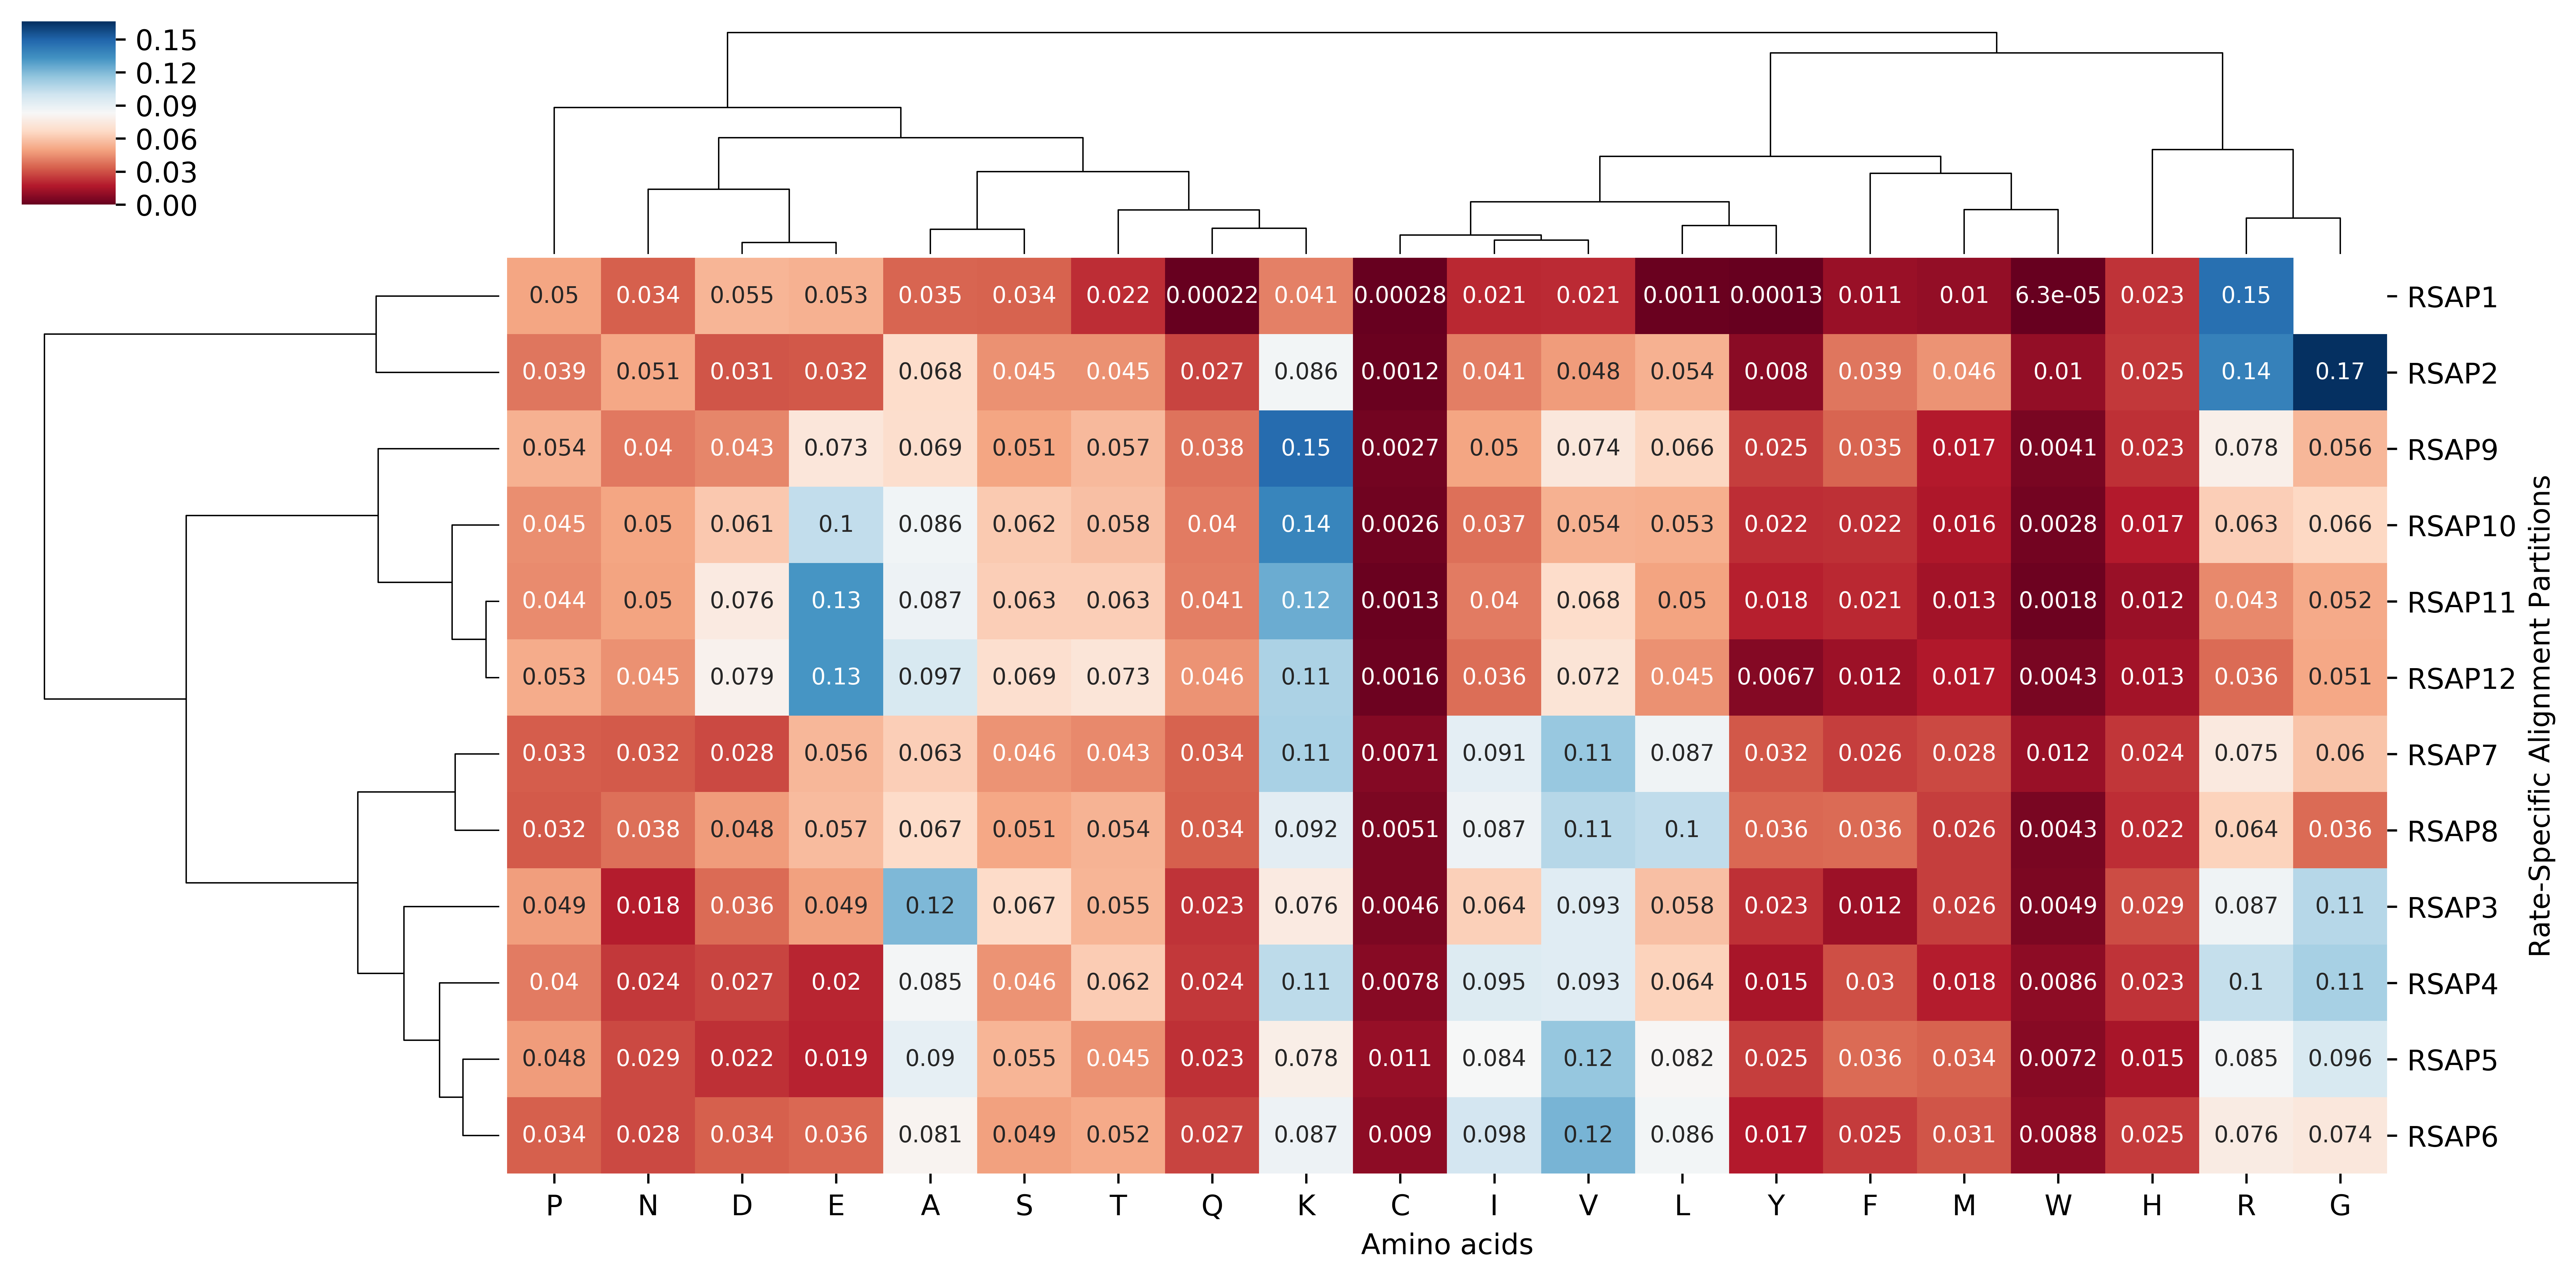

In [184]:
clmap = sns.clustermap(data=df,
                       col_linkage=col_linkage,
                       row_linkage=row_linkage,
                       cmap='RdBu',
                       annot=True,
                       annot_kws={"size": 8})
clmap.fig.set_size_inches(15,7.5)
clmap.fig.set_dpi(600)
clmap.ax_heatmap.set(xlabel='Amino acids', ylabel='Rate-Specific Alignment Partitions')
clmap.fig.savefig('/Users/thiberio/Dropbox (MIT)/site_rates-paper/final figures/supplementary_figures/Figure S5.pdf', 
                  bbox_inches='tight')


In [380]:
manager = multiprocessing.Manager()

tree = ete3.Tree('ribosomal_concat_ml_tree-regular_support.tre-bak')
bacteria     = []
archaea      = []
eukarya      = []
for leaf in tree.get_leaf_names():
    if leaf.startswith('Bacteria'):
        bacteria.append(leaf)
    elif leaf.startswith('Archaea'):
        archaea.append(leaf)
    elif leaf.startswith('Eukaryota'):
        eukarya.append(leaf)
no_bac = manager.list(eukarya+archaea)

In [203]:
def prune_trees(tree_txt):
    tree = ete3.Tree(tree_txt)
    tree.prune(no_bac)
    return tree.write(format=9)

<h3>no trimming</h3>

<h3>just mid</h3>

In [204]:
pool           = multiprocessing.Pool(processes=20)
ufboot         = open('best_phylogenies/lg_f_g/just_mid_evolving_sites.aln_F.ufboot').readlines()
pruned_trees_f = pool.map(prune_trees, ufboot)

pool            = multiprocessing.Pool(processes=20)
ufboot          = open('best_phylogenies/just_mid_evolving_sites.aln.ufboot').readlines()
pruned_trees_fu = pool.map(prune_trees, ufboot)

out = open('lgF_vs_lgFU/just_mid_evolving_sites.FU.ufboot', 'w')
out.write('\n'.join(pruned_trees_fu))
out.close()

out = open('lgF_vs_lgFU/just_mid_evolving_sites.F.ufboot', 'w')
out.write('\n'.join(pruned_trees_f))
out.close()

<h3>no slow</h3>

In [211]:
pool           = multiprocessing.Pool(processes=20)
ufboot         = open('best_phylogenies/lg_f_g/no_slow_evolving_sites.aln_F.ufboot').readlines()
pruned_trees_f = pool.map(prune_trees, ufboot)

pool            = multiprocessing.Pool(processes=20)
ufboot          = open('best_phylogenies/no_slow_evolving_sites.aln.ufboot').readlines()
pruned_trees_fu = pool.map(prune_trees, ufboot)

out = open('lgF_vs_lgFU/no_slow.FU.ufboot', 'w')
out.write('\n'.join(pruned_trees_fu))
out.close()

out = open('lgF_vs_lgFU/no_slow.F.ufboot', 'w')
out.write('\n'.join(pruned_trees_f))
out.close()

<h3>no fast</h3>

In [212]:
pool           = multiprocessing.Pool(processes=20)
ufboot         = open('best_phylogenies/lg_f_g/no_fast_evolving_sites.aln_F.ufboot').readlines()
pruned_trees_f = pool.map(prune_trees, ufboot)

pool            = multiprocessing.Pool(processes=20)
ufboot          = open('best_phylogenies/no_fast_evolving_sites.aln.ufboot').readlines()
pruned_trees_fu = pool.map(prune_trees, ufboot)

out = open('lgF_vs_lgFU/no_fast.FU.ufboot', 'w')
out.write('\n'.join(pruned_trees_fu))
out.close()

out = open('lgF_vs_lgFU/no_fast.F.ufboot', 'w')
out.write('\n'.join(pruned_trees_f))
out.close()

In [364]:
just_mid_dists = []
for line in open('lgF_vs_lgFU/just_mid.rfdist').readlines()[1:]:
    line = line.split()[1:]
    just_mid_dists.extend([int(dist) for dist in line])

no_slow_dists = []
for line in open('lgF_vs_lgFU/no_slow.rfdist').readlines()[1:]:
    line = line.split()[1:]
    no_slow_dists.extend([int(dist) for dist in line])

no_fast_dists = []
for line in open('lgF_vs_lgFU/no_fast.rfdist').readlines()[1:]:
    line = line.split()[1:]
    no_fast_dists.extend([int(dist) for dist in line])

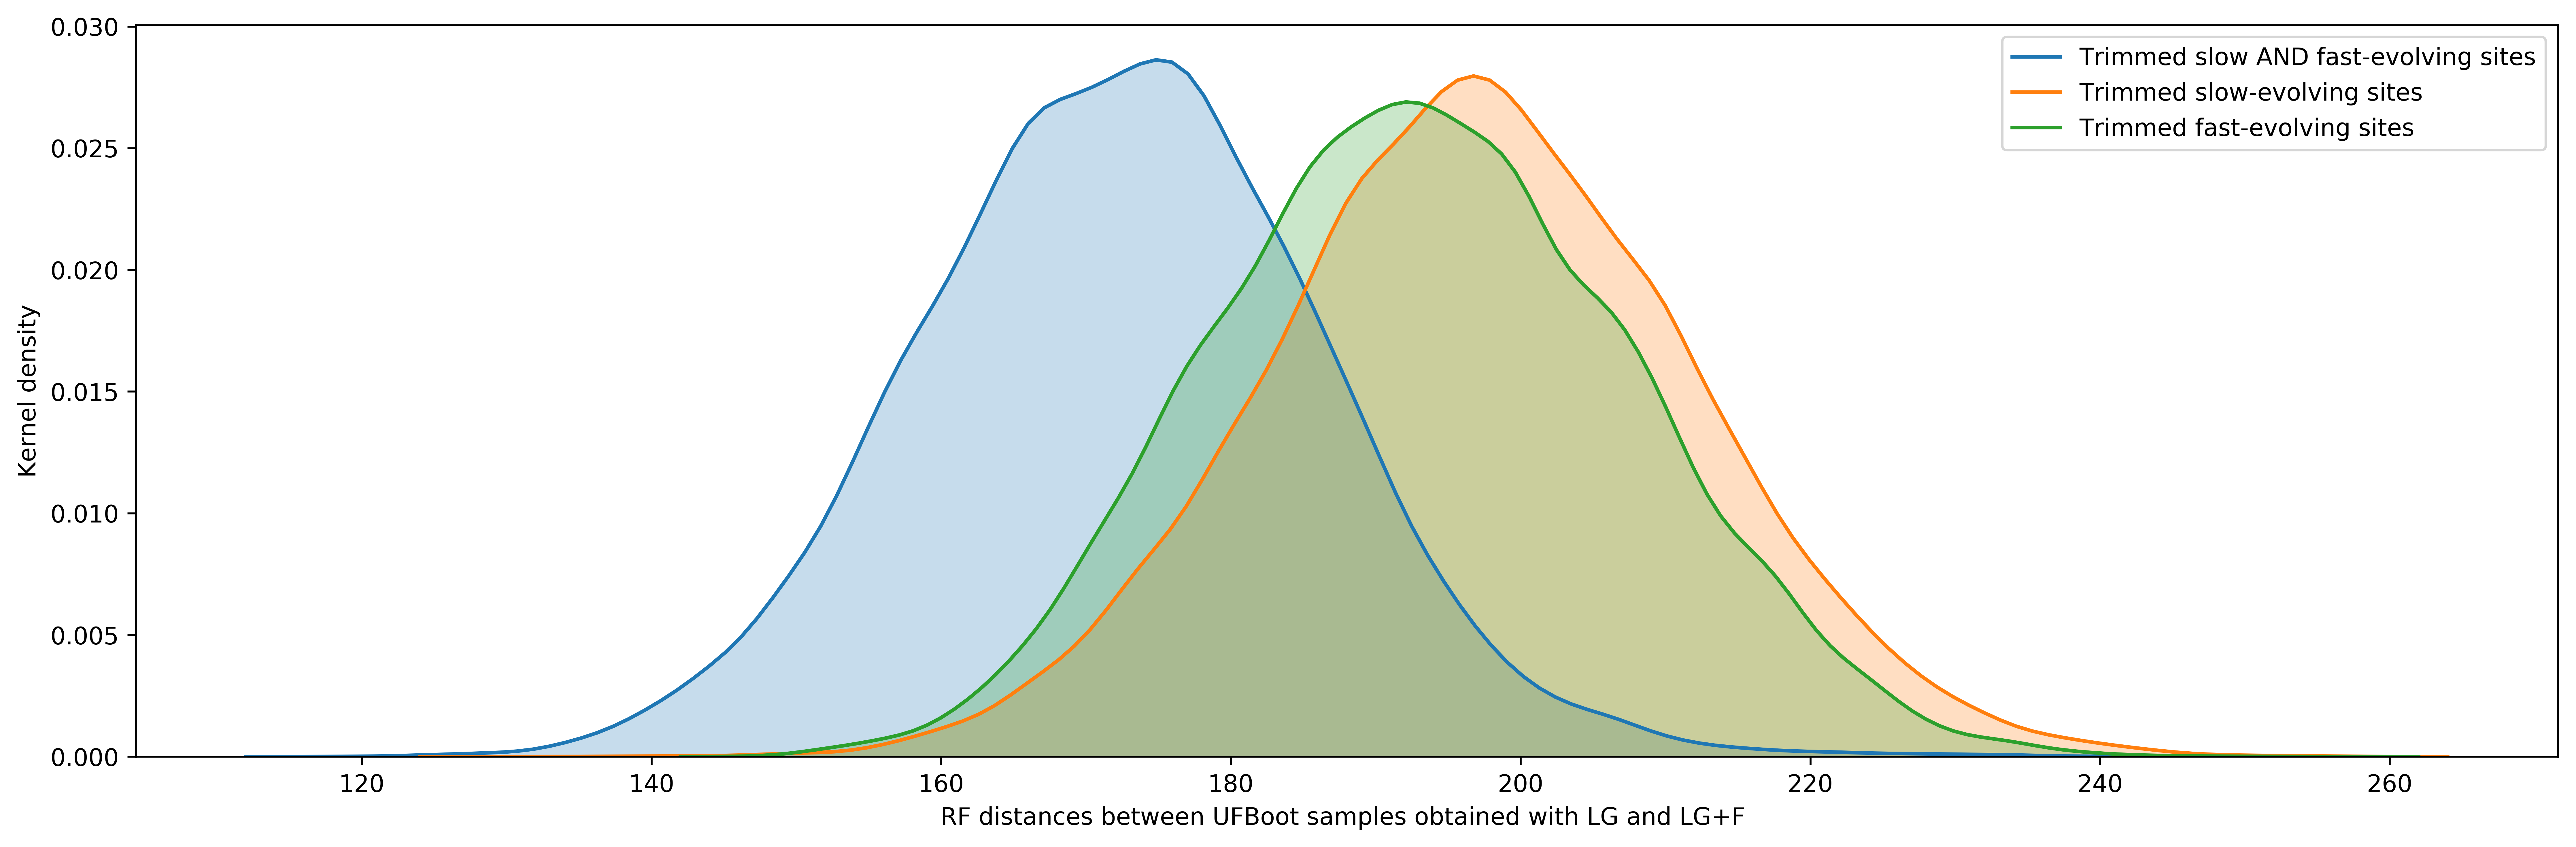

In [396]:
fig, ax = plt.subplots(dpi=600, figsize=(15,5))
sns.kdeplot(just_mid_dists,        shade=True, bw=2,  label='Trimmed slow AND fast-evolving sites')
sns.kdeplot(no_slow_dists,         shade=True,  bw=2, label='Trimmed slow-evolving sites')
sns.kdeplot(no_fast_dists,         shade=True,  bw=2, label='Trimmed fast-evolving sites')
ax.set_xlabel('RF distances between UFBoot samples obtained with LG and LG+F ')
ax.set_ylabel('Kernel density')
fig.tight_layout()
fig.savefig('/Users/thiberio/Dropbox (MIT)/site_rates-paper/final figures/supplementary_figures/Figure SX.pdf')

In [278]:
whole_alignment = AlignIO.read('ribosomal_concat.fasta', 'fasta')

random.seed(12345)
for loop in range(10):
    jackknifed_sites = random.sample(range(2596), 1420)
    out = open('lgF_vs_lgFU/whole_alignment_jackknife/jackknife.%i.aln' % (loop+1), 'w')
    for taxon in whole_alignment:
        tmp = np.asarray(taxon.seq)
        out.write('>{taxon_name}\n{sequence}\n'.format(
            taxon_name=taxon.name,
            sequence=''.join(tmp[jackknifed_sites]))
        )

In [302]:
pool           = multiprocessing.Pool(processes=20)
ufboot         = open('lgF_vs_lgFU/whole_alignment_jackknife/jackknife.1.F.ufboot').readlines()
pruned_trees_f = pool.map(prune_trees, ufboot)

pool            = multiprocessing.Pool(processes=20)
ufboot          = open('lgF_vs_lgFU/whole_alignment_jackknife/jackknife.1.FU.ufboot').readlines()
pruned_trees_fu = pool.map(prune_trees, ufboot)

out = open('lgF_vs_lgFU/whole_alignment_jackknife/whole_alignment.FU.ufboot', 'w')
out.write('\n'.join(pruned_trees_fu))
out.close()

out = open('lgF_vs_lgFU/whole_alignment_jackknife/whole_alignment.F.ufboot', 'w')
out.write('\n'.join(pruned_trees_f))
out.close()

In [399]:
for count in range(1, 11):
    if not os.path.isfile('lgF_vs_lgFU/whole_alignment_jackknife/jackknife.%i.F.ufboot' % count) or \
    not os.path.isfile('lgF_vs_lgFU/whole_alignment_jackknife/jackknife.%i.FU.ufboot' % count):
        continue

    print(count)
    if not os.path.isfile('lgF_vs_lgFU/whole_alignment_jackknife/jackknife_subtree.%i.F.ufboot' % count):
        pool           = multiprocessing.Pool(processes=20)
        ufboot         = open(
            'lgF_vs_lgFU/whole_alignment_jackknife/jackknife.%i.F.ufboot' % count
        ).readlines()
        pruned_trees_f = pool.map(prune_trees, ufboot)
        
        out = open(
            'lgF_vs_lgFU/whole_alignment_jackknife/jackknife_subtree.%i.F.ufboot' % count,
            'w')
        out.write('\n'.join(pruned_trees_f))
        out.close()

    if not os.path.isfile('lgF_vs_lgFU/whole_alignment_jackknife/jackknife_subtree.%i.FU.ufboot' % count):
        pool            = multiprocessing.Pool(processes=20)
        ufboot          = open(
            'lgF_vs_lgFU/whole_alignment_jackknife/jackknife.%i.FU.ufboot' % count
        ).readlines()
        pruned_trees_fu = pool.map(prune_trees, ufboot)

        out = open(
            'lgF_vs_lgFU/whole_alignment_jackknife/jackknife_subtree.%i.FU.ufboot' % count,
            'w')
        out.write('\n'.join(pruned_trees_fu))
        out.close()

1
2
3
4
5
6
7
8
9
10


In [400]:
whole_alignment_dists = []
for count in range(1, 11):
    whole_alignment_dists.append([])
    if os.path.isfile('lgF_vs_lgFU/whole_alignment_jackknife/jackknife_subtree.%i.rfdist' % count):
        for line in open('lgF_vs_lgFU/whole_alignment_jackknife/jackknife_subtree.%i.rfdist'
                         % count).readlines()[1:]:
            line = line.split()[1:]
            whole_alignment_dists[-1].extend([int(dist) for dist in line])

In [401]:
for count, tmp_dist in enumerate(whole_alignment_dists, 1):
    if tmp_dist:
        print(count, ttest_ind(tmp_dist, just_mid_dists))

1 Ttest_indResult(statistic=407.6988376567701, pvalue=0.0)
2 Ttest_indResult(statistic=1813.221000891935, pvalue=0.0)
3 Ttest_indResult(statistic=1066.2770013159175, pvalue=0.0)
4 Ttest_indResult(statistic=3072.806716121726, pvalue=0.0)
5 Ttest_indResult(statistic=763.8530985825417, pvalue=0.0)
6 Ttest_indResult(statistic=1299.4433119429655, pvalue=0.0)
7 Ttest_indResult(statistic=-356.15796473977474, pvalue=0.0)
8 Ttest_indResult(statistic=-526.1069664822792, pvalue=0.0)
9 Ttest_indResult(statistic=1495.030677886257, pvalue=0.0)
10 Ttest_indResult(statistic=544.1110490123357, pvalue=0.0)


In [402]:
for count, tmp_dist in enumerate(whole_alignment_dists, 1):
    if tmp_dist:
        print(count, wilcoxon(tmp_dist, just_mid_dists))

1 WilcoxonResult(statistic=129909864296.0, pvalue=0.0)
2 WilcoxonResult(statistic=2416697874.5, pvalue=0.0)
3 WilcoxonResult(statistic=28896921019.5, pvalue=0.0)
4 WilcoxonResult(statistic=13128647.0, pvalue=0.0)
5 WilcoxonResult(statistic=64401371561.5, pvalue=0.0)
6 WilcoxonResult(statistic=15983547214.5, pvalue=0.0)
7 WilcoxonResult(statistic=143823463772.0, pvalue=0.0)
8 WilcoxonResult(statistic=102888995156.5, pvalue=0.0)
9 WilcoxonResult(statistic=8795113348.0, pvalue=0.0)
10 WilcoxonResult(statistic=101489984223.0, pvalue=0.0)


In [ ]:
fig, axs = plt.subplots(figsize=(15,30), nrows=10, sharex=True, dpi=300)
#sns.kdeplot(whole_alignment_dists[0], shade=True, bw=2,  label='whole alignment jacknife', color='r', ax=axs[0])
#sns.kdeplot(just_mid_dists, shade=True, bw=2, label='mid-rate evolving sites', ax=axs[0])
for count, tmp_dist in enumerate(whole_alignment_dists):
    if tmp_dist:
        axs[count].set_title('jackknife #%i' % (count+1))
        sns.kdeplot(tmp_dist, shade=True, bw=2, color='r', ax=axs[count], label='whole alignment jacknife')
        sns.kdeplot(just_mid_dists, shade=True, bw=2, ax=axs[count], label='mid-rate evolving sites')
fig.savefig('/Users/thiberio/Dropbox (MIT)/site_rates-paper/final figures/supplementary_figures/Figure SY.pdf')